<a href="https://colab.research.google.com/github/khonkaen-iot/dog/blob/main/EP5_ONNX_inferance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Refer  
https://colab.research.google.com/drive/1lIaP7r3I4kSgi3AVYf6fhgRZ56JMpXEL?usp=sharing#scrollTo=j9Vfa4svsJ0U

https://alimustoofaa.medium.com/how-to-load-model-yolov8-onnx-runtime-b632fad33cec

#Load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download jessicali9530/stanford-dogs-dataset

 98% 739M/750M [00:05<00:00, 139MB/s]
100% 750M/750M [00:05<00:00, 135MB/s]


In [4]:
!unzip -q /content/stanford-dogs-dataset.zip

In [5]:
import os

source_dir = '/content/images/Images'

img_paths = []

for root , dir, files in os.walk(source_dir):
  for file in files:
    file_path = os.path.join(root,file)
    img_paths.append(file_path)
print(len(img_paths))

20580


In [7]:
!pip install onnxruntime -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.5 MB/s eta 0:00:00


In [8]:
!cp /content/drive/MyDrive/DogProject/train/train2/weights/best.onnx .

In [9]:
import onnxruntime

In [10]:
import numpy as np
import onnxruntime
import os
import cv2
from PIL import Image
import time

In [11]:
opt_session = onnxruntime.SessionOptions()
opt_session.enable_mem_pattern = False
opt_session.enable_cpu_mem_arena = False
opt_session.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_DISABLE_ALL
# opt_session.genera


In [ ]:
#set Model path

In [12]:
model_path = '/content/best.onnx'
EP_list = ['CUDAExecutionProvider', 'CPUExecutionProvider']

ort_session = onnxruntime.InferenceSession(model_path, providers=EP_list)

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


In [13]:
model_inputs = ort_session.get_inputs()
input_names = [model_inputs[i].name for i in range(len(model_inputs))]
input_shape = model_inputs[0].shape
input_shape

[1, 3, 640, 640]

In [15]:
img_paths[13]

'/content/images/Images/n02092002-Scottish_deerhound/n02092002_9862.jpg'

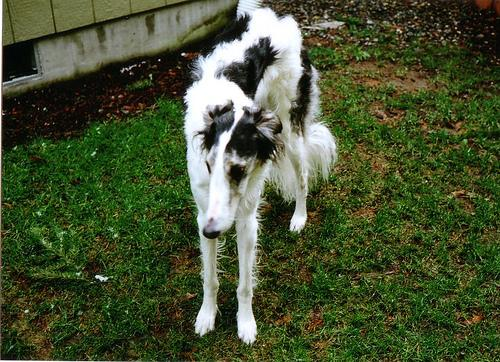

In [34]:
import cv2
import numpy as np
from PIL import Image

image = cv2.imread(img_paths[999])
image_height, image_width = image.shape[:2]
Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# Image.fromarray(image)
# print(image_height, image_width)

In [35]:
input_height, input_width = input_shape[2:]
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized = cv2.resize(image_rgb, (input_width, input_height))

# Scale input pixel value to 0 to 1
input_image = resized / 255.0
input_image = input_image.transpose(2,0,1)
input_tensor = input_image[np.newaxis, :, :, :].astype(np.float32)
input_tensor.shape

(1, 3, 640, 640)

In [36]:
input_tensor

array([[[[0.9843137 , 0.99607843, 0.8       , ..., 0.34117648,
          0.35686275, 0.3764706 ],
         [0.9843137 , 0.99607843, 0.8039216 , ..., 0.32156864,
          0.3372549 , 0.36078432],
         [0.9882353 , 0.99607843, 0.8039216 , ..., 0.2901961 ,
          0.30980393, 0.33333334],
         ...,
         [0.8117647 , 0.8039216 , 0.7921569 , ..., 0.43529412,
          0.34117648, 0.3019608 ],
         [0.92941177, 0.9254902 , 0.92156863, ..., 0.3254902 ,
          0.23921569, 0.18039216],
         [1.        , 1.        , 1.        , ..., 0.25882354,
          0.1764706 , 0.10588235]],

        [[0.98039216, 0.99215686, 0.8039216 , ..., 0.1764706 ,
          0.1882353 , 0.20784314],
         [0.98039216, 0.99215686, 0.8039216 , ..., 0.15686275,
          0.16862746, 0.19215687],
         [0.9843137 , 0.99607843, 0.8039216 , ..., 0.1254902 ,
          0.14117648, 0.16470589],
         ...,
         [0.78039217, 0.77254903, 0.7607843 , ..., 0.5176471 ,
          0.42352942, 0.3

In [37]:
input_names

['images']

In [38]:
model_output = ort_session.get_outputs()
output_names = [model_output[i].name for i in range(len(model_output))]
# ouput_names[0].shap

In [39]:
output_names

['output0']

In [40]:
outputs = ort_session.run(output_names, {input_names[0]: input_tensor})[0]

In [41]:
outputs.shape

(1, 124, 8400)

In [42]:
#squeeze -- > (124,8400)
# .T --> (8400 , 124)

In [43]:
predictions = np.squeeze(outputs).T
predictions.shape

(8400, 124)

In [44]:
conf_thresold = 0.5
# Filter out object confidence scores below threshold
scores = np.max(predictions[:, 4:], axis=1)
predictions = predictions[scores > conf_thresold, :]
scores = scores[scores > conf_thresold]
scores

array([0.81327915, 0.5908553 , 0.6559507 , 0.8510971 , 0.8419187 ,
       0.61589086, 0.78394425, 0.77671695, 0.6733486 , 0.5670134 ],
      dtype=float32)

In [45]:
# Get the class with the highest confidence
class_ids = np.argmax(predictions[:, 4:], axis=1)
class_ids

array([81, 81, 81, 81, 81, 81, 81, 81, 81, 81])

In [46]:
# Get bounding boxes for each object
boxes = predictions[:, :4]

#rescale box
input_shape = np.array([input_width, input_height, input_width, input_height])
boxes = np.divide(boxes, input_shape, dtype=np.float32)
boxes *= np.array([image_width, image_height, image_width, image_height])
boxes = boxes.astype(np.int32)
boxes

array([[260, 177, 157, 354],
       [260, 177, 158, 354],
       [260, 178, 157, 355],
       [261, 178, 158, 357],
       [260, 178, 159, 356],
       [260, 175, 158, 349],
       [261, 175, 159, 350],
       [261, 175, 161, 349],
       [261, 172, 160, 343],
       [261, 172, 161, 343]], dtype=int32)

In [47]:
def nms(boxes, scores, iou_threshold):
    # Sort by score
    sorted_indices = np.argsort(scores)[::-1]

    keep_boxes = []
    while sorted_indices.size > 0:
        # Pick the last box
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)

        # Compute IoU of the picked box with the rest
        ious = compute_iou(boxes[box_id, :], boxes[sorted_indices[1:], :])

        # Remove boxes with IoU over the threshold
        keep_indices = np.where(ious < iou_threshold)[0]

        # print(keep_indices.shape, sorted_indices.shape)
        sorted_indices = sorted_indices[keep_indices + 1]

    return keep_boxes

def compute_iou(box, boxes):
    # Compute xmin, ymin, xmax, ymax for both boxes
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])

    # Compute intersection area
    intersection_area = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)

    # Compute union area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area

    # Compute IoU
    iou = intersection_area / union_area

    return iou

In [53]:
# Apply non-maxima suppression to suppress weak, overlapping bounding boxes
indices = nms(boxes, scores, 0)
print(indices)

[3]


In [54]:
boxes[indices], scores[indices], class_ids[indices]

(array([[261, 178, 158, 357]], dtype=int32),
 array([0.8510971], dtype=float32),
 array([81]))

In [55]:
CLASSES = {0: 'Afghan_hound', 1: 'African_hunting_dog', 2: 'Airedale', 3: 'American_Staffordshire_terrier', 4: 'Appenzeller', 5: 'Australian_terrier', 6: 'Bedlington_terrier', 7: 'Bernese_mountain_dog', 8: 'Blenheim_spaniel', 9: 'Border_collie', 10: 'Border_terrier', 11: 'Boston_bull', 12: 'Bouvier_des_Flandres', 13: 'Brabancon_griffon', 14: 'Brittany_spaniel', 15: 'Cardigan', 16: 'Chesapeake_Bay_retriever', 17: 'Chihuahua', 18: 'Dandie_Dinmont', 19: 'Doberman', 20: 'English_foxhound', 21: 'English_setter', 22: 'English_springer', 23: 'EntleBucher', 24: 'Eskimo_dog', 25: 'French_bulldog', 26: 'German_shepherd', 27: 'German_short-haired_pointer', 28: 'Gordon_setter', 29: 'Great_Dane', 30: 'Great_Pyrenees', 31: 'Greater_Swiss_Mountain_dog', 32: 'Ibizan_hound', 33: 'Irish_setter', 34: 'Irish_terrier', 35: 'Irish_water_spaniel', 36: 'Irish_wolfhound', 37: 'Italian_greyhound', 38: 'Japanese_spaniel', 39: 'Kerry_blue_terrier', 40: 'Labrador_retriever', 41: 'Lakeland_terrier', 42: 'Leonberg', 43: 'Lhasa', 44: 'Maltese_dog', 45: 'Mexican_hairless', 46: 'Newfoundland', 47: 'Norfolk_terrier', 48: 'Norwegian_elkhound', 49: 'Norwich_terrier', 50: 'Old_English_sheepdog', 51: 'Pekinese', 52: 'Pembroke', 53: 'Pomeranian', 54: 'Rhodesian_ridgeback', 55: 'Rottweiler', 56: 'Saint_Bernard', 57: 'Saluki', 58: 'Samoyed', 59: 'Scotch_terrier', 60: 'Scottish_deerhound', 61: 'Sealyham_terrier', 62: 'Shetland_sheepdog', 63: 'Shih-Tzu', 64: 'Siberian_husky', 65: 'Staffordshire_bullterrier', 66: 'Sussex_spaniel', 67: 'Tibetan_mastiff', 68: 'Tibetan_terrier', 69: 'Walker_hound', 70: 'Weimaraner', 71: 'Welsh_springer_spaniel', 72: 'West_Highland_white_terrier', 73: 'Yorkshire_terrier', 74: 'affenpinscher', 75: 'basenji', 76: 'basset', 77: 'beagle', 78: 'black-and-tan_coonhound', 79: 'bloodhound', 80: 'bluetick', 81: 'borzoi', 82: 'boxer', 83: 'briard', 84: 'bull_mastiff', 85: 'cairn', 86: 'chow', 87: 'clumber', 88: 'cocker_spaniel', 89: 'collie', 90: 'curly-coated_retriever', 91: 'dhole', 92: 'dingo', 93: 'flat-coated_retriever', 94: 'giant_schnauzer', 95: 'golden_retriever', 96: 'groenendael', 97: 'keeshond', 98: 'kelpie', 99: 'komondor', 100: 'kuvasz', 101: 'malamute', 102: 'malinois', 103: 'miniature_pinscher', 104: 'miniature_poodle', 105: 'miniature_schnauzer', 106: 'otterhound', 107: 'papillon', 108: 'pug', 109: 'redbone', 110: 'schipperke', 111: 'silky_terrier', 112: 'soft-coated_wheaten_terrier', 113: 'standard_poodle', 114: 'standard_schnauzer', 115: 'toy_poodle', 116: 'toy_terrier', 117: 'vizsla', 118: 'whippet', 119: 'wire-haired_fox_terrier'}


In [56]:
def xywh2xyxy(x):
    # Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

In [ ]:
image_draw = image.copy()
for (bbox, score, label) in zip(xywh2xyxy(boxes[indices]), scores[indices], class_ids[indices]):
    bbox = bbox.round().astype(np.int32).tolist()
    cls_id = int(label)
    cls = CLASSES[cls_id]
    color = (0,255,0)
    cv2.rectangle(image_draw, tuple(bbox[:2]), tuple(bbox[2:]), color, 2)
    cv2.putText(image_draw,
                f'{cls}:{int(score*100)}', (bbox[0], bbox[1] - 2),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.60, [225, 255, 255],
                thickness=1)
Image.fromarray(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))

#Combine all to function

In [61]:
import numpy as np
import onnxruntime
import os
import cv2
from PIL import Image
import time

def pred(img_path , conf_thresold = 0.3 , iou_threshold = 0.3):
  '''
  img_path : single image path -> str
  conf_thresold : Confidence value
  iou_threshold : IoU of boxes
  '''

  #The code you have provided sets up an onnxruntime.SessionOptions object
  opt_session = onnxruntime.SessionOptions()
  opt_session.enable_mem_pattern = False
  opt_session.enable_cpu_mem_arena = False
  opt_session.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_DISABLE_ALL

  #Set model path
  model_path = '/content/best.onnx'
  EP_list = ['CUDAExecutionProvider', 'CPUExecutionProvider']

  ort_session = onnxruntime.InferenceSession(model_path, providers=EP_list)

  # find input
  model_inputs = ort_session.get_inputs()
  input_names = [model_inputs[i].name for i in range(len(model_inputs))]
  input_shape = model_inputs[0].shape

  # input image
  image = cv2.imread(img_path)
  image_height, image_width = image.shape[:2]
  input_height, input_width = input_shape[2:]
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  resized = cv2.resize(image_rgb, (input_width, input_height)) # Resize to 640*640



  # Scale input pixel value to 0 to 1
  input_image = resized / 255.0
  input_image = input_image.transpose(2,0,1)
  input_tensor = input_image[np.newaxis, :, :, :].astype(np.float32)

  # output name
  model_output = ort_session.get_outputs()
  output_names = [model_output[i].name for i in range(len(model_output))]

  #Infreance
  outputs = ort_session.run(output_names, {input_names[0]: input_tensor})[0] # input tensor 1,3,640,640 ---> 1, 124,8400

  # squeeze = 1, 124,8400 ---> 124,8400
  # .T --> 8400,124
  predictions = np.squeeze(outputs).T

  # Filter out object confidence scores below threshold
  scores = np.max(predictions[:, 4:], axis=1)
  predictions = predictions[scores > conf_thresold, :]
  scores = scores[scores > conf_thresold]

  #find class idx
  class_ids = np.argmax(predictions[:, 4:], axis=1)

  # Get bounding boxes for each object
  boxes = predictions[:, :4]

  #rescale box
  input_shape = np.array([input_width, input_height, input_width, input_height])
  boxes = np.divide(boxes, input_shape, dtype=np.float32)
  boxes *= np.array([image_width, image_height, image_width, image_height])
  boxes = boxes.astype(np.int32)
  boxes

  indices = nms(boxes, scores, iou_threshold)

  class_names = {0: 'Afghan_hound', 1: 'African_hunting_dog', 2: 'Airedale', 3: 'American_Staffordshire_terrier', 4: 'Appenzeller', 5: 'Australian_terrier',
                 6: 'Bedlington_terrier', 7: 'Bernese_mountain_dog', 8: 'Blenheim_spaniel', 9: 'Border_collie', 10: 'Border_terrier',
                 11: 'Boston_bull', 12: 'Bouvier_des_Flandres', 13: 'Brabancon_griffon', 14: 'Brittany_spaniel', 15: 'Cardigan',
                 16: 'Chesapeake_Bay_retriever', 17: 'Chihuahua', 18: 'Dandie_Dinmont', 19: 'Doberman', 20: 'English_foxhound',
                 21: 'English_setter', 22: 'English_springer', 23: 'EntleBucher', 24: 'Eskimo_dog', 25: 'French_bulldog',
                 26: 'German_shepherd', 27: 'German_short-haired_pointer', 28: 'Gordon_setter', 29: 'Great_Dane', 30: 'Great_Pyrenees',
                 31: 'Greater_Swiss_Mountain_dog', 32: 'Ibizan_hound', 33: 'Irish_setter', 34: 'Irish_terrier', 35: 'Irish_water_spaniel',
                 36: 'Irish_wolfhound', 37: 'Italian_greyhound', 38: 'Japanese_spaniel', 39: 'Kerry_blue_terrier', 40: 'Labrador_retriever',
                 41: 'Lakeland_terrier', 42: 'Leonberg', 43: 'Lhasa', 44: 'Maltese_dog', 45: 'Mexican_hairless',
                 46: 'Newfoundland', 47: 'Norfolk_terrier', 48: 'Norwegian_elkhound', 49: 'Norwich_terrier', 50: 'Old_English_sheepdog',
                 51: 'Pekinese', 52: 'Pembroke', 53: 'Pomeranian', 54: 'Rhodesian_ridgeback', 55: 'Rottweiler',
                 56: 'Saint_Bernard', 57: 'Saluki', 58: 'Samoyed', 59: 'Scotch_terrier', 60: 'Scottish_deerhound',
                 61: 'Sealyham_terrier', 62: 'Shetland_sheepdog', 63: 'Shih-Tzu', 64: 'Siberian_husky', 65: 'Staffordshire_bullterrier',
                 66: 'Sussex_spaniel', 67: 'Tibetan_mastiff', 68: 'Tibetan_terrier', 69: 'Walker_hound', 70: 'Weimaraner',
                 71: 'Welsh_springer_spaniel', 72: 'West_Highland_white_terrier', 73: 'Yorkshire_terrier', 74: 'affenpinscher', 75: 'basenji',
                 76: 'basset', 77: 'beagle', 78: 'black-and-tan_coonhound', 79: 'bloodhound', 80: 'bluetick',
                 81: 'borzoi', 82: 'boxer', 83: 'briard', 84: 'bull_mastiff', 85: 'cairn',
                 86: 'chow', 87: 'clumber', 88: 'cocker_spaniel', 89: 'collie', 90: 'curly-coated_retriever',
                 91: 'dhole', 92: 'dingo', 93: 'flat-coated_retriever', 94: 'giant_schnauzer', 95: 'golden_retriever',
                 96: 'groenendael', 97: 'keeshond', 98: 'kelpie', 99: 'komondor', 100: 'kuvasz',
                 101: 'malamute', 102: 'malinois', 103: 'miniature_pinscher', 104: 'miniature_poodle', 105: 'miniature_schnauzer',
                 106: 'otterhound', 107: 'papillon', 108: 'pug', 109: 'redbone', 110: 'schipperke',
                 111: 'silky_terrier', 112: 'soft-coated_wheaten_terrier', 113: 'standard_poodle', 114: 'standard_schnauzer', 115: 'toy_poodle',
                 116: 'toy_terrier', 117: 'vizsla', 118: 'whippet', 119: 'wire-haired_fox_terrier'}


  #Draw image
  image_draw = image.copy()
  for (bbox, score, label) in zip(xywh2xyxy(boxes[indices]), scores[indices], class_ids[indices]):
      print(f"bbox : {bbox} , score: {score} , label : {label}")
      bbox = bbox.round().astype(np.int32).tolist()
      cls_id = int(label)
      cls = class_names[cls_id]
      color = (0,255,0)
      cv2.rectangle(image_draw, tuple(bbox[:2]), tuple(bbox[2:]), color, 2)
      cv2.putText(image_draw,
                  f'{cls}:{int(score*100)}', (bbox[0], bbox[1] - 2),
                  cv2.FONT_HERSHEY_SIMPLEX,
                  0.60, [225, 255, 255],
                  thickness=1)
  return Image.fromarray(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))

In [62]:
img_paths[53]

'/content/images/Images/n02092002-Scottish_deerhound/n02092002_6955.jpg'

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


bbox : [  0 141 270 497] , score: 0.6597597599029541 , label : 36


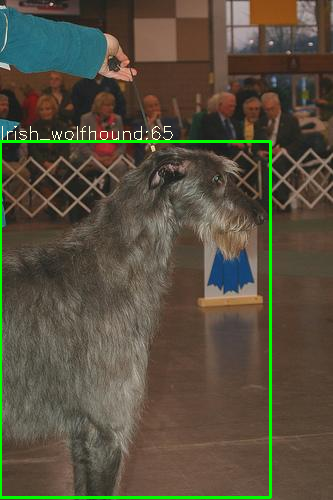

In [63]:
pred(img_paths[53] , conf_thresold = 0.3 , iou_threshold = 0.3)

In [64]:
img_paths[1]

'/content/images/Images/n02092002-Scottish_deerhound/n02092002_6114.jpg'

In [ ]:
pred(img_paths[1] , conf_thresold = 0.3 , iou_threshold = 0)

In [67]:
img_paths[343]

'/content/images/Images/n02093754-Border_terrier/n02093754_874.jpg'

In [ ]:
pred(img_paths[343] , conf_thresold = 0.3 , iou_threshold = 0)

In [70]:
img_paths[1234]

'/content/images/Images/n02107683-Bernese_mountain_dog/n02107683_5204.jpg'

In [ ]:
pred(img_paths[1234] , conf_thresold = 0.3 , iou_threshold = 0)